Enter # of neurons1000
Enter # of memory states25
Enter # of connected neighbours k150
Enter # of iterations each run1000
Enter # of runs to average over1000
Select memory state which when added noise gives initial state2


100%|██████████| 1000/1000 [127:01:00<00:00, 457.26s/it]      


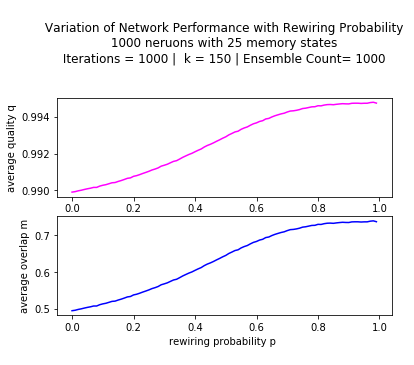

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: yash
"""

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from random import choice
from matplotlib import cm
import datetime
from tqdm import tqdm
from random import randrange
import random

div = 100
#yes it works
n = int(input('Enter # of neurons'))
m = int(input('Enter # of memory states'))
flip = round(0.25 * n)

MemoryMatrix = np.zeros((m, n))

for a in range(0, m):
    mem = []
    for i in range(0, n):
        x = choice([1, -1])
        mem.append(x)

    MemoryMatrix[a] = mem
    x = 0

k = int(input('Enter # of connected neighbours k'))
n_i = int(input('Enter # of iterations each run'))
ensembleCount = int(input('Enter # of runs to average over'))
target = int(input('Select memory state which when added noise gives initial state'))

suffix = datetime.datetime.now().strftime("%m%d_%H%M%S")
filename = "_".join([str(n), str(m), str(k), str(n_i), str(ensembleCount), suffix])
np.savetxt(filename + "-ms-s.csv", np.column_stack((np.transpose(MemoryMatrix))), delimiter=",", fmt='%s')

OverlapMatrixn = np.zeros((ensembleCount, div))  # initiate overlap matrix
EtaMatrixn = np.zeros((ensembleCount, div))  # initiate quality matrix

for b in tqdm(range(ensembleCount)):
    u = []
    u = MemoryMatrix[target].copy()  # copy target M to initial state
    hammingtemp = overlaptemp = 0
    hammingavg = overlapavg = 0
    Y = []
    Y2 = []
    X = []

    rho = 0
    p = 0

    n_init = random.randint(0, (n - flip))  # start at a random position in the initial state
    n_fin = n_init + flip

    for count in range(n_init, n_fin):  # sequentially pick up 25% of bits and flip them
        u[count] = (MemoryMatrix[target][count] * -1)

    for rho in (range(100)):  # for this given random matrix, loop over different p values

        p = (rho / div)
        hammingtemp = overlaptemp = 0
        hammingval = overlapval = 0
        q = 0

        g = nx.watts_strogatz_graph(n, k, p)

        # g.pos = {}
        # for x in range(4):
        #      for y in range(4):
        #         g.pos[y * 4 + x] = (x, -y)

        # set the initial state
        st = 0
        for st in range(0, n):
            g.nodes[st]['state'] = u[st]

        # nx.draw(g, pos = g.pos, cmap = cm.jet, vmin = -1, vmax = 1, node_color = [g.nodes[i]['state'] for i in
        # g.nodes]) plt.show() print ("Initial Graph")

        # train the network
        for i, j in g.edges:
            weight = 0
            alpha = 0
            for alpha in range(0, m):
                weight = weight + (MemoryMatrix[alpha][i] * MemoryMatrix[alpha][j])
            g.edges[i, j]['weight'] = (weight / n)

        # evolve according to hopfield dynamics, n_i iterations
        for z in range(0, n_i):
            i = choice(list(g.nodes))
            s = sum([g.edges[i, j]['weight'] * g.nodes[j]['state'] for j in g.neighbors(i)])
            g.nodes[i]['state'] = 1 if s > 0 else -1 if s < 0 else g.nodes[i]['state']

            # nx.draw(g, pos = g.pos, cmap = cm.jet, vmin = -1, vmax = 1, node_color = [g.nodes[i]['state'] for i in
            # g.nodes]) plt.show()
            z = z + 1

        # calculate hamming distances and overlap for all the memory states

        for i in list(g.nodes):
            overlaptemp += (MemoryMatrix[target][i] * g.nodes[i]['state'])
            hammingtemp += abs(g.nodes[i]['state'] - MemoryMatrix[target][i])

        hammingval = (hammingtemp / (m * 2))
        overlapval = (overlaptemp / n)

        q = ((n - hammingval) / n)
        X.append(p)
        Y.append(q)
        Y2.append(overlapval)


    OverlapMatrixn[b] = Y2
    EtaMatrixn[b] = Y

    b = b + 1

col_totalsE = [sum(x) for x in zip(*EtaMatrixn)]
col_totalsO = [sum(x) for x in zip(*OverlapMatrixn)]

col_totalsEavg = [(x / ensembleCount) for x in col_totalsE]
col_totalsOavg = [(x / ensembleCount) for x in col_totalsO]

# set up figure and axes
plt.subplot(2, 1, 1)
plt.plot(X, col_totalsEavg, color="magenta")
plt.title("\n Variation of Network Performance with Rewiring Probability \n %s neruons with %s memory states \n "
          "Iterations = %s |  k = %s | Ensemble Count= ""%s \n \n" % (n, m, n_i, k, ensembleCount))
plt.ylabel("average quality q")

plt.subplot(2, 1, 2)
plt.ylabel("average overlap m")
plt.xlabel("rewiring probability p \n")
plt.plot(X, col_totalsOavg, color="blue")

suffix = datetime.datetime.now().strftime("%m%d_%H%M%S")
filename = "_".join([str(n), str(m), str(k), str(n_i), str(ensembleCount), suffix])
plt.autoscale()
plt.savefig(filename, dpi=200, bbox_inches = "tight")
plt.show()

np.savetxt(filename + "-s-Q.csv", np.column_stack((X, col_totalsEavg)), delimiter=",", fmt='%s')
np.savetxt(filename + "-s-O.csv", np.column_stack((X, col_totalsOavg)), delimiter=",", fmt='%s')